In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="poster", style='ticks')

%matplotlib inline

In [2]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, cellLoc='center', 
                         rowLabels = data.index, colLabels=data.columns, **kwargs)
    
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [3]:
df = pd.read_table("./datasets/correlated_gene_bigtable.tsv", sep="\t", 
                   usecols = ['gene_symbol', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
print(df.shape)
df.head()

(1899, 5)


,gene_symbol,BRCA,TN-BRCA,nonTN-BRCA,EndoR-BRCA
0,AASS,Yes,Yes,Yes,No
1,AATF,Yes,No,No,No
2,ABCA2,Yes,Yes,Yes,No
3,ABCA2,Yes,Yes,Yes,No
4,ABCB5,Yes,No,No,No


In [4]:
corr_genes = {'Union': set(df['gene_symbol']), 
              'BRCA': set(df.loc[df['BRCA']=='Yes', 'gene_symbol']), 
              'TN-BRCA': set(df.loc[df['TN-BRCA']=='Yes', 'gene_symbol']), 
              'nonTN-BRCA': set(df.loc[df['nonTN-BRCA']=='Yes', 'gene_symbol']), 
              'EndoR-BRCA': set(df.loc[df['EndoR-BRCA']=='Yes', 'gene_symbol'])}

for k, v in corr_genes.items():
    print("{} {}".format(k, len(v)))

Union 1295
BRCA 922
TN-BRCA 472
nonTN-BRCA 582
EndoR-BRCA 105


In [5]:
corr_genes_labels = [k + "\n(n=" + str(len(v)) + ")" for k, v in corr_genes.items()]

# CancerMine

In [6]:
cancermine = pd.read_table("/home/singuyen/epiCa/CancerMine/cancermine_collated.tsv", sep="\t", 
                           usecols=['role', 'gene_normalized'])

databases = {'Driver': set(cancermine.loc[cancermine['role'] == 'Driver', 'gene_normalized']), 
             'Tumor suppressor': set(cancermine.loc[cancermine['role'] == 'Tumor_Suppressor', 'gene_normalized']), 
             'Oncogene': set(cancermine.loc[cancermine['role'] == 'Oncogene', 'gene_normalized'])}

for k, v in databases.items():
    print("{} {}".format(k, len(v)))

Driver 905
Tumor suppressor 2128
Oncogene 2716


In [7]:
databases_labels = [k.replace(" ", "\n") + "\n(n=" + str(len(v)) + ")" for k, v in databases.items()]

In [8]:
fraction = {}
count = {}
genename = {}

import scipy.stats as stats
pvalues = {}
M = 26674

for d, g in databases.items():
    fraction[d] = {}
    count[d] = {}
    genename[d] = {}
    pvalues[d] = {}

    for group, genes in corr_genes.items():
        t = len(genes) # Try set `t=len(g)`
        c = len(genes & g)
        f = c/t
        p = stats.hypergeom.sf(c - 1, M, len(g), len(genes))
        fraction[d][group] = f
        count[d][group] = c
        genename[d][group] = genes & g
        pvalues[d][group] = p

In [9]:
countdf = pd.DataFrame(count)
countdf = countdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
countdf

,Driver,Tumor suppressor,Oncogene
Union,130,285,329
BRCA,104,225,244
TN-BRCA,54,91,118
nonTN-BRCA,69,124,156
EndoR-BRCA,12,23,30


In [10]:
fracdf = pd.DataFrame(fraction)
fracdf = fracdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
fracdf

,Driver,Tumor suppressor,Oncogene
Union,0.100386,0.220077,0.254054
BRCA,0.112798,0.244035,0.264642
TN-BRCA,0.114407,0.192797,0.250000
nonTN-BRCA,0.118557,0.213058,0.268041
EndoR-BRCA,0.114286,0.219048,0.285714


[Text(0.5, 0, 'Driver\n(n=905)'),
 Text(1.5, 0, 'Tumor\nsuppressor\n(n=2128)'),
 Text(2.5, 0, 'Oncogene\n(n=2716)')]

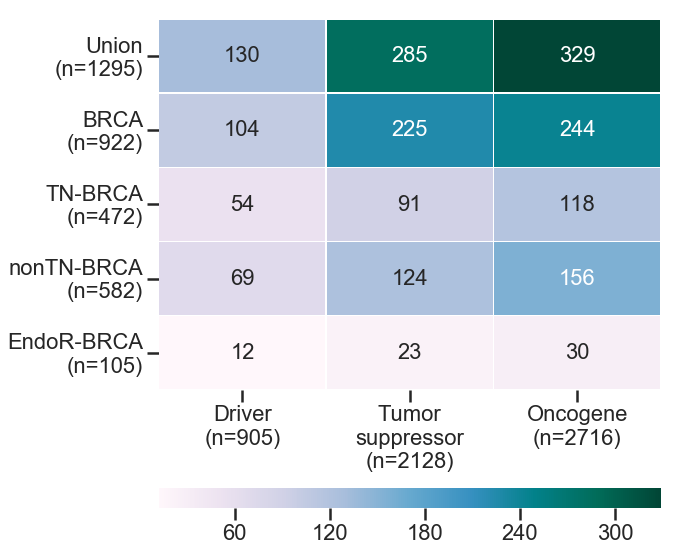

In [11]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .5}
fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(9, 9))

g = sns.heatmap(countdf, annot=True, annot_kws={"size": 22}, fmt='.0f', ax=ax,
                linewidths=.5, cmap="PuBuGn", 
                cbar_ax = cbar_ax, cbar_kws={"orientation": "horizontal"})

g.set_yticklabels(corr_genes_labels)
g.set_xticklabels(databases_labels)

In [12]:
pdf = pd.DataFrame(pvalues)
pdf = pdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
pdf

,Driver,Tumor suppressor,Oncogene
Union,3.618426e-29,3.999375e-59,1.379122e-58
BRCA,2.312906e-27,1.582659e-54,1.612653e-46
TN-BRCA,6.519546e-15,2.225532e-15,1.115434e-20
nonTN-BRCA,1.414610e-19,2.023710e-24,1.442103e-30
EndoR-BRCA,2.337348e-04,7.127284e-06,1.141231e-07


pdf.loc['Union'] = pdf.loc['Union'].round(59)
pdf.loc['BRCA'] = pdf.loc['BRCA'].round(55)
pdf.loc['TN-BRCA'] = pdf.loc['TN-BRCA'].round(21)
pdf.loc['nonTN-BRCA'] = pdf.loc['nonTN-BRCA'].round(31)
pdf.loc['EndoR-BRCA'] = pdf.loc['EndoR-BRCA'].round(8)

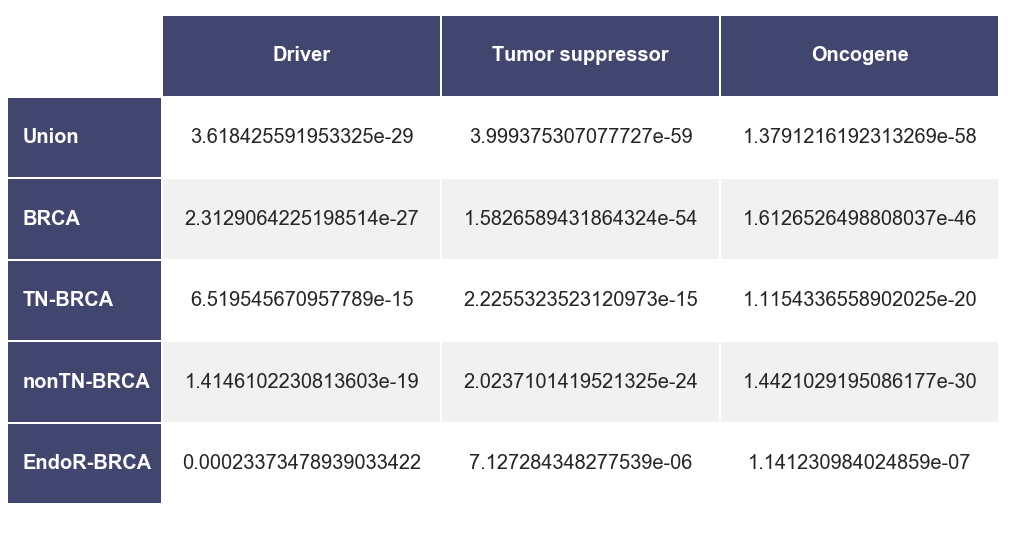

In [13]:
render_mpl_table(pdf, header_columns=0, col_width=5.0, row_height=1.5, font_size=20)

# CancerMine - Breast cancer associated

In [14]:
cancermine_breast = pd.read_table("/home/singuyen/epiCa/CancerMine/cancermine_collated.breast.tsv", sep="\t", 
                                  usecols=['role', 'gene_normalized'])

databases = {'Driver': set(cancermine_breast.loc[cancermine_breast['role'] == 'Driver', 'gene_normalized']), 
             'Tumor suppressor': set(cancermine_breast.loc[cancermine_breast['role'] == 'Tumor_Suppressor', 'gene_normalized']), 
             'Oncogene': set(cancermine_breast.loc[cancermine_breast['role'] == 'Oncogene', 'gene_normalized'])}

for k, v in databases.items():
    print("{} {}".format(k, len(v)))

Driver 223
Tumor suppressor 541
Oncogene 653


In [15]:
databases_labels = [k.replace(" ", "\n") + "\n(n=" + str(len(v)) + ")" for k, v in databases.items()]

In [16]:
fraction = {}
count = {}
genename = {}

import scipy.stats as stats
pvalues = {}
M = 26674

for d, g in databases.items():
    fraction[d] = {}
    count[d] = {}
    genename[d] = {}
    pvalues[d] = {}

    for group, genes in corr_genes.items():
        t = len(genes) # Try set `t=len(g)`
        c = len(genes & g)
        f = c/t
        p = stats.hypergeom.sf(c - 1, M, len(g), len(genes))
        fraction[d][group] = f
        count[d][group] = c
        genename[d][group] = genes & g
        pvalues[d][group] = p

In [17]:
countdf = pd.DataFrame(count)
countdf = countdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
countdf

,Driver,Tumor suppressor,Oncogene
Union,33,86,89
BRCA,27,69,66
TN-BRCA,14,37,33
nonTN-BRCA,18,42,46
EndoR-BRCA,2,6,9


In [18]:
fracdf = pd.DataFrame(fraction)
fracdf = fracdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
fracdf

,Driver,Tumor suppressor,Oncogene
Union,0.025483,0.066409,0.068726
BRCA,0.029284,0.074837,0.071584
TN-BRCA,0.029661,0.078390,0.069915
nonTN-BRCA,0.030928,0.072165,0.079038
EndoR-BRCA,0.019048,0.057143,0.085714


[Text(0.5, 0, 'Driver\n(n=223)'),
 Text(1.5, 0, 'Tumor\nsuppressor\n(n=541)'),
 Text(2.5, 0, 'Oncogene\n(n=653)')]

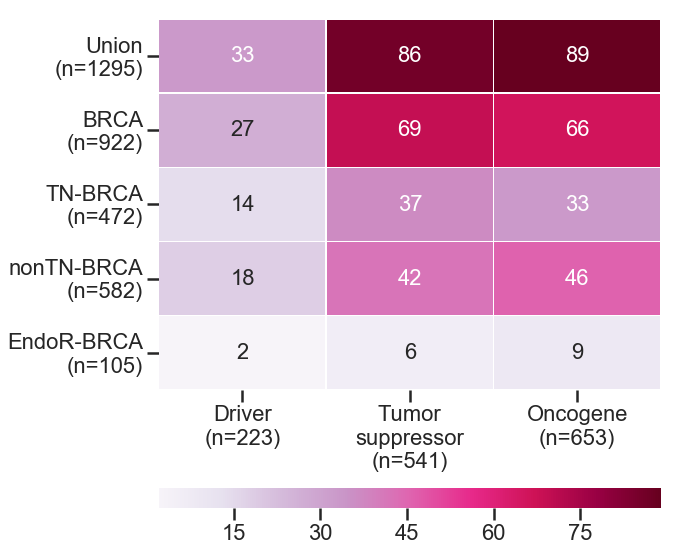

In [19]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .5}
fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(9, 9))

g = sns.heatmap(countdf, annot=True, annot_kws={"size": 22}, fmt='.0f', ax=ax,
                linewidths=.5, cmap="PuRd", 
                cbar_ax = cbar_ax, cbar_kws={"orientation": "horizontal"})

g.set_yticklabels(corr_genes_labels)
g.set_xticklabels(databases_labels)

In [20]:
pdf = pd.DataFrame(pvalues)
pdf = pdf.reindex(['Union', 'BRCA', 'TN-BRCA', 'nonTN-BRCA', 'EndoR-BRCA'])
pdf

,Driver,Tumor suppressor,Oncogene
Union,1.171128e-08,1.717890e-22,1.068172e-18
BRCA,1.731280e-08,6.775428e-21,6.969719e-15
TN-BRCA,4.810418e-05,2.919205e-12,8.313073e-08
nonTN-BRCA,2.218728e-06,1.454860e-12,3.661141e-12
EndoR-BRCA,2.191280e-01,2.020831e-02,1.114647e-03


decimals = pd.Series([9, 22, 19], 
                     index=['Driver', 'Tumor suppressor', 'Oncogene'])
pdf = pdf.round(decimals)
pdf.loc['EndoR-BRCA'] = pdf.loc['EndoR-BRCA'].round(5)

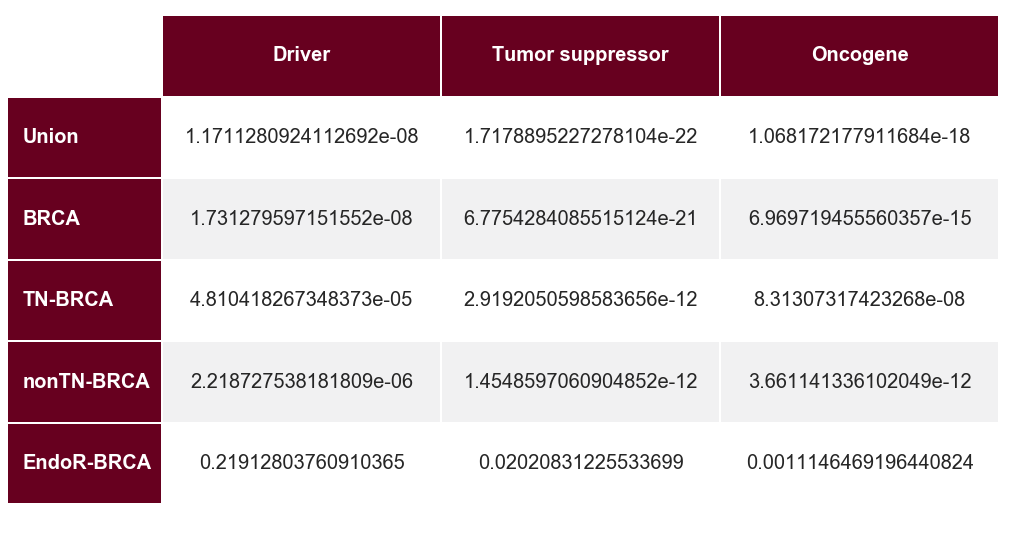

In [21]:
render_mpl_table(pdf, header_columns=0, header_color='#67001f', 
                 col_width=5.0, row_height=1.5, font_size=20)

# Others

In [4]:
tsg_dir='/home/singuyen/epiCa/TSGene/Human_TSGs.names.and.aliases'
brcatsg_dir='/home/singuyen/epiCa/TSGene/BRCA_down_regulated_TSgenes.genes'
onco_dir= '/home/singuyen/epiCa/NCG6/NCG6_oncogenes.genes'
cancer_dir='/home/singuyen/epiCa/NCG6/NCG6_cancergenes.genes'

with open(tsg_dir) as file:
    tsg=set([line.rstrip('\n') for line in file])

with open(brcatsg_dir) as file:
    brcatsg=set([line.rstrip('\n') for line in file])

with open(onco_dir) as file:
    onco=set([line.rstrip('\n') for line in file])

with open(cancer_dir) as file:
    cancergenes=set([line.rstrip('\n') for line in file])

databases={
            'TSGene': tsg, 
            'BRCATSGene': brcatsg, 
           'NCG6Onco': onco, 'NCG6Cancer': cancergenes, 'Union': cancergenes.union(tsg, brcatsg, onco)}

for k, v in databases.items():
    print("{} {}".format(k, len(v)))

TSGene 5196
BRCATSGene 589
NCG6Onco 282
NCG6Cancer 2372
Union 7260


In [5]:
fraction = {}
count = {}
genename = {}

import scipy.stats as stats
pvalues = {}
M = 26674

for d, g in databases.items():
    fraction[d] = {}
    count[d] = {}
    genename[d] = {}
    pvalues[d] = {}

    for group, genes in corr_genes.items():
        t = len(genes) # Try set `t=len(g)`
        c = len(genes & g)
        f = c/t
        p = stats.hypergeom.sf(c - 1, M, len(g), len(genes))
        fraction[d][group] = f
        count[d][group] = c
        genename[d][group] = genes & g
        pvalues[d][group] = p

In [6]:
countdf = pd.DataFrame(count)
countdf = countdf.reindex(['Union', 'BRCA', 'nonTN-BRCA', 'TN-BRCA', 'EndoR-BRCA'])
countdf

,TSGene,BRCATSGene,NCG6Onco,NCG6Cancer,Union
Union,126,78,46,262,337
BRCA,92,58,33,195,247
nonTN-BRCA,63,38,19,117,158
TN-BRCA,49,25,14,77,110
EndoR-BRCA,15,6,6,23,34


In [7]:
fracdf = pd.DataFrame(fraction)
fracdf = fracdf.reindex(['Union', 'BRCA', 'nonTN-BRCA', 'TN-BRCA', 'EndoR-BRCA'])
fracdf

,TSGene,BRCATSGene,NCG6Onco,NCG6Cancer,Union
Union,0.097297,0.060232,0.035521,0.202317,0.260232
BRCA,0.099783,0.062907,0.035792,0.211497,0.267896
nonTN-BRCA,0.108247,0.065292,0.032646,0.201031,0.271478
TN-BRCA,0.103814,0.052966,0.029661,0.163136,0.233051
EndoR-BRCA,0.142857,0.057143,0.057143,0.219048,0.323810


In [8]:
pdf = pd.DataFrame(pvalues)
pdf = pdf.reindex(['Union', 'BRCA', 'nonTN-BRCA', 'TN-BRCA', 'EndoR-BRCA'])
pdf

,TSGene,BRCATSGene,NCG6Onco,NCG6Cancer,Union
Union,1.000000,8.050696e-16,4.904856e-13,2.659953e-38,0.846665
BRCA,1.000000,9.506327e-13,1.106831e-09,4.001191e-31,0.629305
nonTN-BRCA,1.000000,3.390584e-09,1.602271e-05,2.857454e-17,0.531283
TN-BRCA,1.000000,5.894837e-05,5.489107e-04,1.393025e-07,0.977441
EndoR-BRCA,0.933856,2.906836e-02,8.884011e-04,4.058988e-05,0.140259
